<a href="https://colab.research.google.com/github/hausersamuel/Datenanalysis_II_project/blob/main/Sol_1_GNN_Tutorial_Pierini_annotaded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted from TensorFlow-GNN tutorials notebook.
https://github.com/tensorflow/gnn/blob/main/examples/notebooks/intro_mutag_example.ipynb

Dataset citation:

https://chrsmrrs.github.io/datasets/docs/home/
Riesen, K. and Bunke, H.: IAM Graph Database Repository for Graph Based Pattern Recognition and Machine Learning. In: da Vitora Lobo, N. et al. (Eds.), SSPR&SPR 2008, LNCS, vol. 5342, pp. 287-297, 2008.

AIDS Antiviral Screen Data (2004)



# Import libraries

In [1]:
#install tf-gnn
!pip install -q tensorflow_gnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 646.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.8/836.8 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.5/792.5 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 74.8 MB/s eta 0:

In [2]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"  # For TF2.16+.
import tensorflow_gnn as tfgnn
import tensorflow as tf
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# Set global font size for all text
plt.rcParams.update({'font.size': 14})  # Adjust to your desired font size


In [4]:
#set random seed for reproducibility
np.random.seed(42)

## Useful functions

In [5]:
import pickle
from tqdm import tqdm
def to_one_hot(label, num_classes):
    """
    Converts a single label into a one-hot encoded vector.

    Parameters:
    label (int): The label to be one-hot encoded.
    num_classes (int): The total number of unique classes.

    Returns:
    numpy.ndarray: A one-dimensional one-hot encoded vector.
    """
    one_hot_vector = np.zeros(num_classes)
    one_hot_vector[label] = 1
    return one_hot_vector.tolist()
def convert_nx_to_graph_tensor(G, num_classes, num_classes_edges):
    """
    Converts a networkx graph with existing node and edge features to a tensorflow_gnn.GraphTensor object.

    Args:
        G (networkx.Graph): The networkx graph to be converted.
                            Node features should be stored in G.nodes[node_id]['feature'].
                            Edge features should be stored in G.edges[edge]['feature'] (optional).

    Returns:
        tensorflow_gnn.GraphTensor: The equivalent graph in GraphTensor format.
    """
    # Get the number of nodes and edges
    num_nodes = G.number_of_nodes()
    edge_list = list(G.edges)

    # Convert edges to a tensor
    edges_tensor = tf.convert_to_tensor(edge_list, dtype=tf.int32)
    # for e in G.edges:
    #     print(G.edges[e])


    # Extract node features (assuming they are stored in 'feature' attribute)
    node_features_list = [G.nodes[node_id]['attributes']+to_one_hot(G.nodes[node_id]['labels'], num_classes=num_classes) for node_id in G.nodes]

    # node_features_list = [0.0 for _ in node_features_list]
    # node_features_list += [to_one_hot(G.nodes[node_id]['labels'], num_classes=num_classes) for node_id in G.nodes]

    node_features = tf.convert_to_tensor(node_features_list, dtype=tf.float32)
    # print(node_features.shape)
    # 0/0

    edge_features_list = [to_one_hot(G.edges[edge]['labels'], num_classes=num_classes_edges) for edge in G.edges]
    edge_features = tf.convert_to_tensor(edge_features_list, dtype=tf.float32)

    # print(G.graph)
    # 0/0

    # Create the GraphTensor
    graph_tensor = tfgnn.GraphTensor.from_pieces(
        context=tfgnn.Context.from_fields(
            features={'label': G.graph['classes']}),
        node_sets={"atoms": tfgnn.NodeSet.from_fields(
            sizes=[num_nodes],
            features={tfgnn.HIDDEN_STATE: node_features}
        )},
        edge_sets={"bonds": tfgnn.EdgeSet.from_fields(
            sizes=[len(edge_list)],
            adjacency=tfgnn.Adjacency.from_indices(
                source=("atoms", edges_tensor[:, 0]),
                target=("atoms", edges_tensor[:, 1])
            ),
            features={tfgnn.HIDDEN_STATE: edge_features}
        )}
    )

    return graph_tensor


def load(filename, limit=-1):
    graph_db = pickle.load(open(filename, "rb"))

    tf_graphs = []
    N = len(graph_db)
    if limit > 0:
        N = limit
    for i in tqdm(range(N)):
        tf_g = convert_nx_to_graph_tensor(graph_db[i], 38, num_classes_edges=3)
        # print(graph_db[i], graph_db[i], graph_db[i].graph)
        # print(tf_g.node_sets['nodes'])

        node_sert = tf_g.node_sets['atoms']
        features_tensor = node_sert.features.values()
        features_matrix = [tensor.numpy() for tensor in features_tensor]

        edges = tf_g.edge_sets['bonds']
        edges_tensor = edges.features.values()
        edge_f_matrix = [tensor.numpy() for tensor in edges_tensor]

        tf_graphs.append(tf_g)

    return tf_graphs

## Load and preprocess data

In [6]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1IHy7C6uZnAQucvW3jI-_fs6vAQfcn3HQ' -O graph_db.bin

--2024-10-29 13:00:57--  https://docs.google.com/uc?export=download&id=1IHy7C6uZnAQucvW3jI-_fs6vAQfcn3HQ
Resolving docs.google.com (docs.google.com)... 172.253.118.102, 172.253.118.138, 172.253.118.113, ...
Connecting to docs.google.com (docs.google.com)|172.253.118.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1IHy7C6uZnAQucvW3jI-_fs6vAQfcn3HQ&export=download [following]
--2024-10-29 13:00:57--  https://drive.usercontent.google.com/download?id=1IHy7C6uZnAQucvW3jI-_fs6vAQfcn3HQ&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.12.132, 2404:6800:4003:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.12.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2847517 (2.7M) [application/octet-stream]
Saving to: ‘graph_db.bin’

graph_db.bin        100%[===================>]   2.71M  --.-KB/s   

In [7]:
tf_graphs = load('graph_db.bin', 2000) # Set the second argument to -1 later once you wanna load everything
shuffled_list = np.random.permutation(tf_graphs) #shuffle data

100%|██████████| 2000/2000 [00:39<00:00, 50.50it/s]


In [8]:
# Split the list into 20% (val), 20% (test), and 60% (train)
# Calculate the split indices
split_1 = int(len(shuffled_list) * 0.2)
split_2 = split_1 + int(len(shuffled_list) * 0.2)

val_graphs = shuffled_list[:split_1]
test_graphs = shuffled_list[split_1:split_2]
train_graphs = shuffled_list[split_2:]

In [9]:
def plot_networkx_graph(G: nx.Graph, plot_with_ids=False, node_color='lightblue', plot_vectorial_rep=False, font_size=15, node_size=1000):
    numeric_to_str_atomic_codes = { 0: 'C',1: 'O',2: 'N',3: 'Cl',4: 'F',5: 'S',6: 'Se',7: 'P',8: 'Na',9: 'I',
                                    10: 'Co',11: 'Br',12: 'Li',13: 'Si',14: 'Mg',15: 'Cu',16: 'As',17: 'B',
                                    18: 'Pt',19: 'Ru',20: 'K',21: 'Pd',22: 'Au',23: 'Te',24: 'W',25: 'Rh',26: 'Zn',
                                    27: 'Bi',28: 'Pb',29: 'Ge',30: 'Sb',31: 'Sn',32: 'Ga',33: 'Hg',34: 'Ho',35: 'Tl',
                                    36: 'Ni',37: 'Tb',}

    # Set up the figure
    plt.figure(figsize=(8, 8))

    # Get positions for all nodes
    pos = nx.spring_layout(G, seed=8)  # You can use other layouts like circular, shell, etc.

    # Draw the graph
    nx.draw(G, pos, with_labels=False, node_color=node_color, node_size=node_size, font_size=font_size, font_color='black')

    # Draw node labels (in this case, features for illustration)
    node_labels = nx.get_node_attributes(G, 'feature')
    if plot_with_ids == False:
      node_label_atom = {k: numeric_to_str_atomic_codes[v[0]] for k, v in node_labels.items()}
    else:
      node_label_atom = {k:k for k, v in node_labels.items()}
    if plot_vectorial_rep:
      node_label_atom = {k:'[...]' for k, v in node_labels.items()}

    nx.draw_networkx_labels(G, pos, labels=node_label_atom)

    # Draw edge labels (optional)
    edge_labels = nx.get_edge_attributes(G, 'feature')
    edge_labels = {k:np.argmax(v)+1 for k,v in edge_labels.items()}

    if plot_vectorial_rep:
      edge_labels = {k:'[...]' for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(i, j): str(edge_labels[(i, j)]) for i, j in G.edges()})

    # Display the graph
    plt.title('Graph Visualization')
    plt.show()


# Example usage:
# plot_networkx_graph(my_networkx_graph)


def graph_tensor_to_networkx(graph_tensor: tfgnn.GraphTensor) -> nx.Graph:
    # Create an empty NetworkX graph
    G = nx.Graph()

    # Extract node features and add them to the graph
    for node_set_name, node_set in graph_tensor.node_sets.items():
        node_features = node_set.features[tfgnn.HIDDEN_STATE].numpy()  # Extract features as NumPy arrays
        node_sizes = node_set.sizes.numpy()  # Extract node set sizes

        # Add nodes with features to the graph
        for i in range(node_sizes[0]):
            G.add_node(i, feature=node_features[i])

    # Extract edge features and add them to the graph
    for edge_set_name, edge_set in graph_tensor.edge_sets.items():
        edge_features = edge_set.features[tfgnn.HIDDEN_STATE].numpy()  # Extract edge features as NumPy arrays
        edge_sizes = edge_set.sizes.numpy()  # Extract edge set sizes

        adjacency = edge_set.adjacency  # Get the adjacency structure
        source_nodes = adjacency.source.numpy()
        target_nodes = adjacency.target.numpy()

        # Add edges with features to the graph
        for i in range(edge_sizes[0]):
            G.add_edge(source_nodes[i], target_nodes[i], feature=edge_features[i])

    return G

## Checkpoint #1

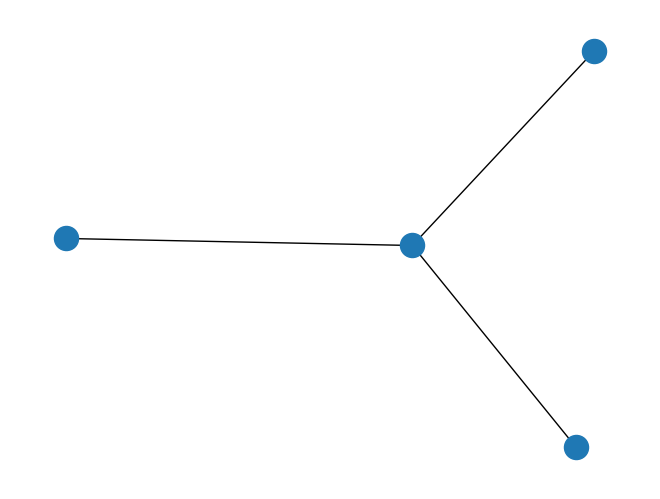

In [10]:
# TODO #1: Get one of the train graph and plot it with networkx
my_graph = train_graphs[5]
my_graph_nx = graph_tensor_to_networkx(my_graph)
nx.draw(my_graph_nx)

## Checkpoint #2

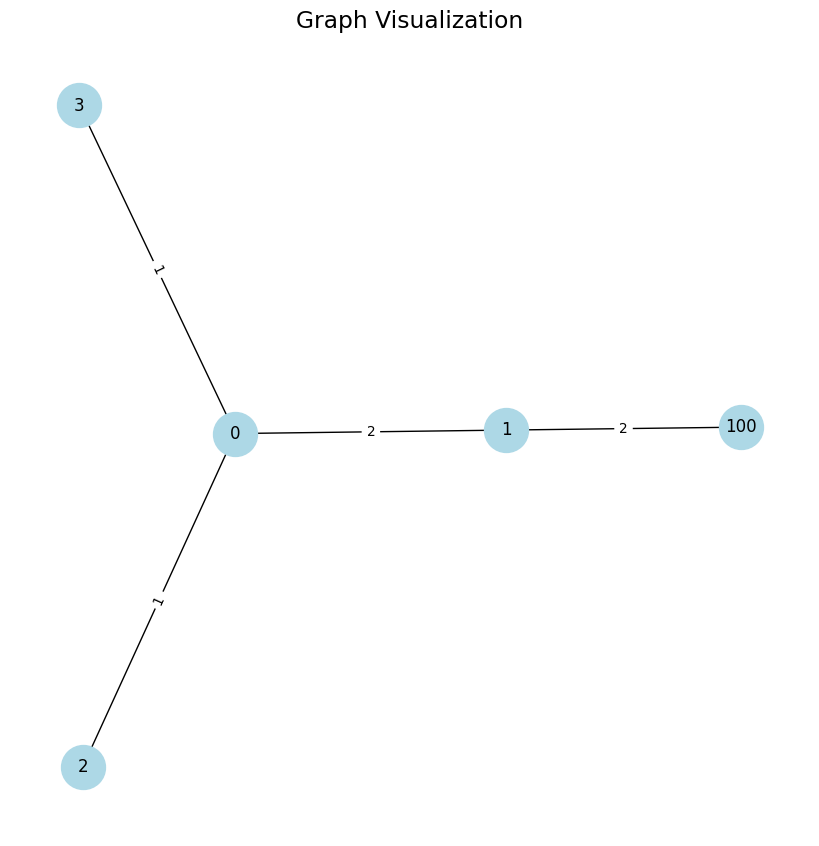

In [ ]:
my_graph = train_graphs[5]
my_graph_nx = graph_tensor_to_networkx(my_graph)

my_graph_nx.add_node(100, feature=[0])
my_graph_nx.add_edge(100, 1, feature=to_one_hot(1, 3))

plot_networkx_graph(my_graph_nx, plot_with_ids=True)

In [ ]:
graph_tensor_spec = tfgnn.GraphTensorSpec.from_piece_specs(
    context_spec=tfgnn.ContextSpec.from_field_specs(features_spec={
        'label': tf.TensorSpec(shape=(1,), dtype=tf.int32)
    }),
    node_sets_spec={
        'atoms':
            tfgnn.NodeSetSpec.from_field_specs(
                features_spec={
                    tfgnn.HIDDEN_STATE:
                        tf.TensorSpec((None, 42), tf.float32)
                },
                sizes_spec=tf.TensorSpec((1,), tf.int32)
            )
    },
    edge_sets_spec={
        'bonds':
            tfgnn.EdgeSetSpec.from_field_specs(
                features_spec={
                    tfgnn.HIDDEN_STATE:
                        tf.TensorSpec((None, 3), tf.float32)
                }
                , sizes_spec=tf.TensorSpec((1,), tf.int32)
                ,
                adjacency_spec=tfgnn.AdjacencySpec.from_incident_node_sets(
                    'atoms', 'atoms'))
    })


# This is not actually used.. It is to simplify the above code for understanding
graph_spec_illustration = {
    "context": { # This graph level
        "features": {
            "label": {
                "shape": (1,),
                "dtype": "int32"
            }
        }
    },
    "node_sets": { # Can have multiple types of nodes here for heterogeneous GNNs
        "atoms": { # Here it is only atoms
            "features": { # And then every node set has features
                tfgnn.HIDDEN_STATE: {
                    "shape": (None, 42),
                    "dtype": "float32"
                }
            },
            "sizes": { # and sizes
                "shape": (1,),
                "dtype": "int32"
            }
        }
    },
    "edge_sets": { # And then you have edges (can be different types for different GNNs but here it is pretty simple
        "bonds": { # It is only the bonds between the atoms in the molecules
            "features": {
                tfgnn.HIDDEN_STATE: {
                    "shape": (None, 3),
                    "dtype": "float32"
                }
            },
            "sizes": {
                "shape": (1,),
                "dtype": "int32"
            },
            "adjacency": { # The bonds is between atoms and atoms of course (can be more complicated for heterogenous GNNs)
                "source_node_set": "atoms",
                "target_node_set": "atoms"
            }
        }
    }
}


In [ ]:
# Create a generator function to yield GraphTensors
def graph_tensor_generator():
    for graph_tensor in train_graphs:
        yield graph_tensor, graph_tensor.context.features['label']


def graph_tensor_generator_validate():
    for graph_tensor in val_graphs:
        yield graph_tensor, graph_tensor.context.features['label']

In [ ]:
# Create a dataset from the generator
train_dataset = tf.data.Dataset.from_generator(
    graph_tensor_generator,  # The generator function
    output_signature=(graph_tensor_spec, tf.TensorSpec(shape=(1,), dtype=tf.int32))  # Specify the output signature
)

# Create a dataset from the generator
val_dataset = tf.data.Dataset.from_generator(
    graph_tensor_generator_validate,  # The generator function
    output_signature=(graph_tensor_spec, tf.TensorSpec(shape=(1,), dtype=tf.int32))  # Specify the output signature
)

In [ ]:
batch_size = 30
# Now you can batch the dataset
# batched_dataset = dataset.batch(batch_size=32)
train_ds_batched = train_dataset.batch(batch_size=batch_size).repeat()
val_ds_batched = val_dataset.batch(batch_size=batch_size)

# Define/build the model

In [ ]:
# CHECKPOINT #4

def _build_model(
        graph_tensor_spec,
        # Dimensions of initial states.
        node_dim=16,
        edge_dim=16,
        # Dimensions for message passing.
        message_dim=64,
        next_state_dim=64,
        # Dimension for the logits.
        num_classes=2,
        # Other hyperparameters.
        l2_regularization=5e-4,
        dropout_rate=0.5,
):
    # Model building with Keras's Functional API starts with an input object
    # (a placeholder for the eventual inputs). Here is how it works for
    # GraphTensors:
    input_graph = tf.keras.layers.Input(type_spec=graph_tensor_spec)

    # IMPORTANT: All TF-GNN modeling code assumes a GraphTensor of shape []
    # in which the graphs of the input batch have been merged to components of
    # one contiguously indexed graph. (There are no edges between components,
    # so no information flows between them.)
    graph = input_graph.merge_batch_to_components()

    # Nodes and edges have one-hot encoded input features. Sending them through
    # a Dense layer effectively does a lookup in a trainable embedding table.
    def change_node_state(node_set, *, node_set_name):
        # Since we only have one node set, we can ignore node_set_name.
        return tf.keras.layers.Dense(node_dim)(node_set[tfgnn.HIDDEN_STATE])

    def change_edge_state(edge_set, *, edge_set_name):
        return tf.keras.layers.Dense(edge_dim)(edge_set[tfgnn.HIDDEN_STATE])

    graph = tfgnn.keras.layers.MapFeatures(
        node_sets_fn=change_node_state, edge_sets_fn=change_edge_state)(
        graph)

    graph = tfgnn.keras.layers.MapFeatures(
        node_sets_fn=change_node_state, edge_sets_fn=change_edge_state)(
        graph)

    # This helper function is just a short-hand for the code below.
    def dense(units, activation="relu"):
        """A Dense layer with regularization (L2 and Dropout)."""
        regularizer = tf.keras.regularizers.l2(l2_regularization)
        return tf.keras.Sequential([
            tf.keras.layers.Dense(
                units,
                activation=activation,
                kernel_regularizer=regularizer,
                bias_regularizer=regularizer),
            tf.keras.layers.Dropout(dropout_rate)
        ])


    # Adapt the following for the first parameter of NodeSetUpdate:
    '''
    {EDGE_NAME: tfgnn.keras.layers.SimpleConv(
                 sender_edge_feature=XX,
                 sender_node_feature=XX,
                 receiver_feature=XX,
                 message_fn=MESSAGE_FN,
                 reduce_type=REDUCE_TYPE,
                 receiver_tag=tfgnn.TARGET)}
    '''

    # Adapt the following for the second parameter of of NodeSetUpdate:
    ##
    # tfgnn.keras.layers.NextStateFromConcat(MESSAGE_FN)


    graph = tfgnn.keras.layers.GraphUpdate(
        node_sets={
            'atoms': tfgnn.keras.layers.NodeSetUpdate(
                {'bonds': tfgnn.keras.layers.SimpleConv(
                 sender_edge_feature=None,
                 sender_node_feature=tfgnn.HIDDEN_STATE,
                 receiver_feature=None,
                 message_fn=dense(message_dim),
                 reduce_type='sum')},
                tfgnn.keras.layers.NextStateFromConcat(dense(next_state_dim)))}
    )(graph)

    graph = tfgnn.keras.layers.GraphUpdate(
        node_sets={
            'atoms': tfgnn.keras.layers.NodeSetUpdate(
                {'bonds': tfgnn.keras.layers.SimpleConv(
                 sender_edge_feature=tfgnn.HIDDEN_STATE,
                 sender_node_feature=tfgnn.HIDDEN_STATE,
                 receiver_feature=None,
                 message_fn=dense(message_dim),
                 reduce_type='sum')},
                tfgnn.keras.layers.NextStateFromConcat(dense(next_state_dim)))}
    )(graph)


    graph = tfgnn.keras.layers.GraphUpdate(
        node_sets={
            'atoms': tfgnn.keras.layers.NodeSetUpdate(
                {'bonds': tfgnn.keras.layers.SimpleConv(
                 sender_edge_feature=tfgnn.HIDDEN_STATE,
                 sender_node_feature=tfgnn.HIDDEN_STATE,
                 receiver_feature=tfgnn.HIDDEN_STATE,
                 message_fn=dense(message_dim),
                 reduce_type='sum')},
                tfgnn.keras.layers.NextStateFromConcat(dense(next_state_dim)))}
    )(graph)


    # After the GNN has computed a context-aware representation of the NODE_NAME,
    # the model reads out a representation for the graph as a whole by averaging
    # (pooling) nde states into the graph context. The context is global to each
    # input graph of the batch, so the first dimension of the result corresponds
    # to the batch dimension of the inputs (same as the labels).
    readout_features = tfgnn.keras.layers.Pool(
        tfgnn.CONTEXT, "mean", node_set_name='atoms')(graph)

    # Put a linear classifier on top (not followed by dropout).
    logits = tf.keras.layers.Dense(1)(readout_features)

    # Build a Keras Model for the transformation from input_graph to logits.
    return tf.keras.Model(inputs=[input_graph], outputs=[logits])

model = _build_model(train_dataset.element_spec[0])


In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.BinaryAccuracy(threshold=0.),
           tf.keras.metrics.BinaryCrossentropy(from_logits=True)]

model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss=loss, metrics=metrics)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_62 (InputLayer)       [()]                      0         
                                                                 
 input.merge_batch_to_compo  ()                        0         
 nents_13 (InstanceMethod)                                       
                                                                 
 map_features_24 (MapFeatur  ()                        752       
 es)                                                             
                                                                 
 map_features_25 (MapFeatur  ()                        544       
 es)                                                             
                                                                 
 graph_update_18 (GraphUpda  ()                        6272      
 te)                                                       

# Fit the model

In [ ]:
print(int(len(train_graphs)/batch_size))
history = model.fit(train_ds_batched,
                    steps_per_epoch=int(len(train_graphs)/batch_size),
                    epochs=25,
                    validation_data=val_ds_batched)

40
Epoch 1/25
40/40 [==============================] - 9s 138ms/step - loss: 1.1380 - binary_accuracy: 0.2300 - binary_crossentropy: 0.9252 - val_loss: 0.8825 - val_binary_accuracy: 0.7850 - val_binary_crossentropy: 0.6705
Epoch 2/25
40/40 [==============================] - 4s 95ms/step - loss: 0.8936 - binary_accuracy: 0.5692 - binary_crossentropy: 0.6824 - val_loss: 0.8385 - val_binary_accuracy: 0.7850 - val_binary_crossentropy: 0.6280
Epoch 3/25
40/40 [==============================] - 4s 101ms/step - loss: 0.8109 - binary_accuracy: 0.7825 - binary_crossentropy: 0.6012 - val_loss: 0.8059 - val_binary_accuracy: 0.7850 - val_binary_crossentropy: 0.5970
Epoch 4/25
40/40 [==============================] - 6s 150ms/step - loss: 0.7708 - binary_accuracy: 0.8067 - binary_crossentropy: 0.5626 - val_loss: 0.7763 - val_binary_accuracy: 0.7850 - val_binary_crossentropy: 0.5689
Epoch 5/25
40/40 [==============================] - 4s 94ms/step - loss: 0.7438 - binary_accuracy: 0.8067 - binary_cro

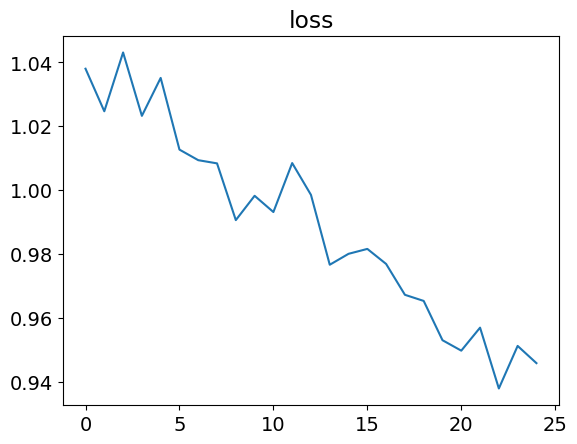

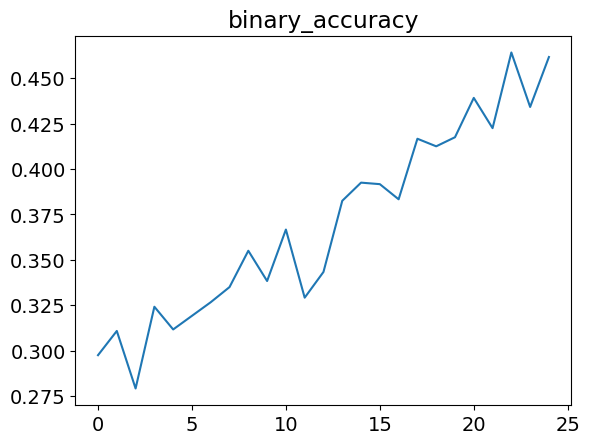

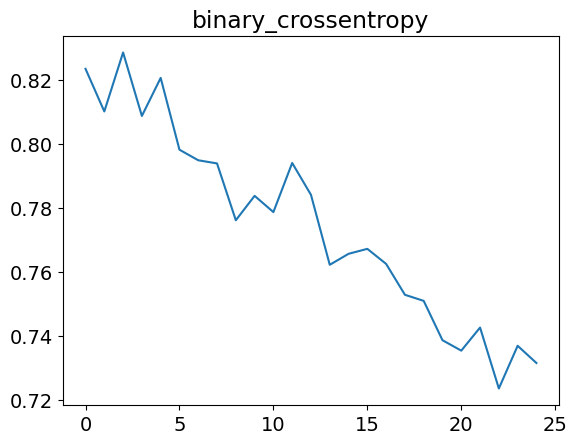

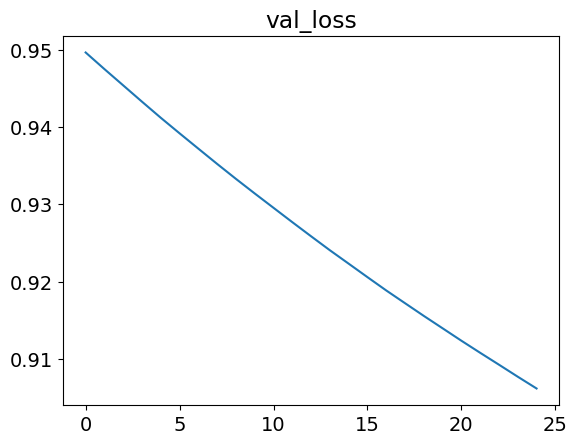

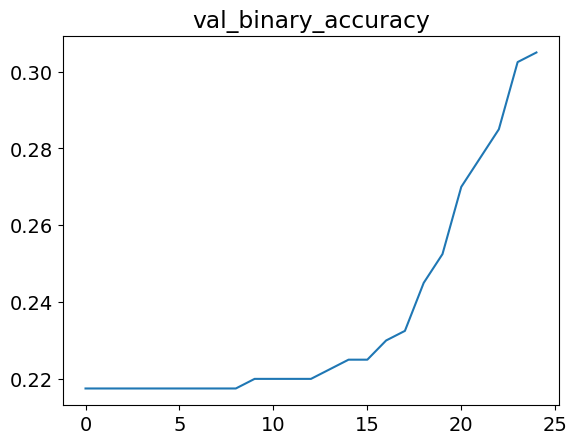

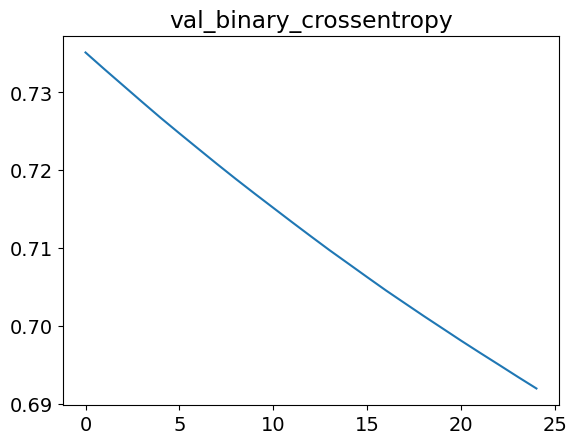

In [ ]:
for k, hist in history.history.items():
  plt.plot(hist)
  plt.title(k)
  plt.show()